# Notebook for finding the optimal window width for the Keweenawan APWP

### Following the method of Gallo et al., 2023, we look for the optimal averaging window size, that is, an optimal balance between overfitting and underfitting of the Moving averages. We achieve this through a modified version of the leasts squares cross-validation technique. We follow the steps below:

1. Subdivide the original dataset of site-mean directions into a training set and a validation set, with each representing 50 percent of the original dataset.
2. Using the training set, construct an APWP for different values of the window width $L$ using the workflow outilned in Section 2.2. Follow the same procedure for the validation set.
3. To evaluate the performance of the trained model, calculate the mean of the time-varying great circle distance between contemporary poles on the training and validation APWPs. This measure provides a robust metric that decreases as the window width grows, since all the VGPs collapse into a single pole which would be the same in the training and validation curves. There comes a point when increasing the smoothing parameter (i.e. reducing model complexity) will not yield significant performance gains, this point can be seen as an elbow.
4. Fit a smoothing spline to the dataset and locate the elbow of the curve through the elbow-finding technique of Satopaa et al. (2011). This point represents the value of the optimal window width or smoothing parameter.
5. Repeat steps 1-4 a number of times (typically $10^3$) and take the median of the ensemble distribution of the calculated optimal values (Figure Sy).

## Import scientific Python libraries

Import scipy python libraries as well as functions written for the project within vgptools.

In [11]:
import os
import numpy as np
import pandas as pd

from pmagpy import ipmag, pmag
from kneed import KneeLocator # Satopaa et al.(2011) knee finding technique (https://github.com/arvkevi/kneed#citation)
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from vgptools.utils_APWPs import weighted_moving_average_APWP
%matplotlib inline

## load the compiled data

In [2]:
Keweenawan_track_sites = pd.read_csv('../data/pmag_compiled/Keweenawan_track_sites.csv')
Keweenawan_track_sites.head()

,pole_name,age,age_high,age_low,age_unit,age_uncertainty,citations,dir_alpha95,dir_polarity,dir_dec,...,dir_n_samples,dir_tilt_correction,dir_r,vgp_lat_rev,vgp_lon_rev,vgp_dm,vgp_dp,paleolatitude,Plon,Plat
0,Osler reverse lower,1108.0,1110.0,1105.15,Ma,uniform,Swanson-Hysell et al. 2014,2.7,r,79.7,...,NaN,NaN,NaN,33.098356,229.588330,NaN,NaN,-54.692457,229.588330,33.098356
1,Osler reverse lower,1108.0,1110.0,1105.15,Ma,uniform,Swanson-Hysell et al. 2014,6.4,r,74.1,...,NaN,NaN,NaN,30.447349,231.831739,NaN,NaN,-54.393410,231.831739,30.447349
2,Osler reverse lower,1108.0,1110.0,1105.15,Ma,uniform,Swanson-Hysell et al. 2014,6.8,r,87.5,...,NaN,NaN,NaN,35.321456,223.912252,NaN,NaN,-52.341346,223.912252,35.321456
3,Osler reverse lower,1108.0,1110.0,1105.15,Ma,uniform,Swanson-Hysell et al. 2014,4.9,r,75.7,...,NaN,NaN,NaN,29.952660,229.585495,NaN,NaN,-52.630096,229.585495,29.952660
4,Osler reverse lower,1108.0,1110.0,1105.15,Ma,uniform,Swanson-Hysell et al. 2014,3.9,r,109.8,...,NaN,NaN,NaN,45.769076,210.954452,NaN,NaN,-49.396782,210.954452,45.769076


### The following block iterates different window widths training and validation subsets (takes ~27 min)

This process involves iterating through different window widths, ranging from 5 million years to 45 million years, and dividing the original dataset into two subgroups, one for training and one for validation. We then run a Moving Average (MA) on the training subgroup and in the validations group. The time-varying distance between the Moving averages on training and validation sets is calculated and we store its mean and standard deviation values. The underlying idea is to train the model with the training subgroup using a certain window width and then evaluate its performance on the validation subgroup with the same window width. This iteration is done for different window widths to find the optimal window size.

In [19]:
%%time

min_age = Keweenawan_track_sites['age'].min()
max_age = Keweenawan_track_sites['age'].max()
step = 1
window_lengths = range(5,20,1) 

df_ensemble = pd.DataFrame(columns = ['step_size','window_length','n_training','mean_distance','std_distance'])

np.random.seed(0) # seed for reproducibility

for window in window_lengths:

    for i in range(50):

        df_tmp = pd.DataFrame()

        # subdivide the original dataset into a train and validation subsets
        train, test = train_test_split(Keweenawan_track_sites, test_size=0.5)  

        mean_distances = []
        std_distances = []
        
        # running mean on the train set
        RM_train_ = weighted_moving_average_APWP(train, 'Plon', 'Plat', 'age', 'pole_name', window, step, max_age, min_age)
        # running mean on the validation set
        RM_test_ = weighted_moving_average_APWP(test, 'Plon', 'Plat', 'age', 'pole_name', window, step, max_age, min_age)

        distances = []

        for t in RM_train_.age.unique():

            df_train = RM_train_[RM_train_['age']==t]
            df_test = RM_test_[RM_test_['age']==t]

            try:
                gcd = pmag.angle([df_train['plon'].iat[0], df_train['plat'].iat[0]],
                                 [df_test['plon'].iat[0], df_test['plat'].iat[0]])
            except:
                continue

            distances.append(gcd)

        mean_distances.append(np.array(distances).mean())
        std_distances.append(np.array(distances).std())

        df_ensemble.loc[len(df_ensemble)] = [step, window, i, np.array(mean_distances).mean(), np.array(std_distances).mean()]

df_ensemble.head()

CPU times: user 9min, sys: 3.75 s, total: 9min 3s
Wall time: 9min 9s


,step_size,window_length,n_training,mean_distance,std_distance
0,1.0,5.0,0.0,16.539747,36.413607
1,1.0,5.0,1.0,19.160477,39.218019
2,1.0,5.0,2.0,22.157387,46.102095
3,1.0,5.0,3.0,25.139429,53.412799
4,1.0,5.0,4.0,18.142421,37.370894


In [20]:
df = df_ensemble.copy()

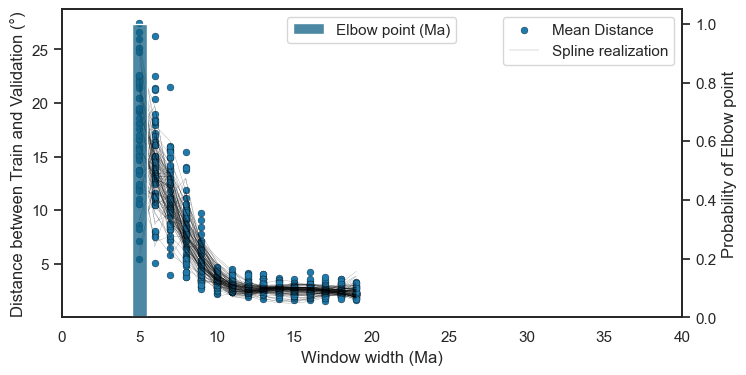

In [21]:
sns.reset_orig
fig,ax = plt.subplots(figsize=(8,4))
sns.set_theme(style="white") 
ax.set_ylabel('Distance between Train and Validation (°)')
ax.set_xlabel('Window width (Ma)')    

np.random.seed(0) # seed for reproducibility

# Plot the 
ax.scatter(x=df["window_length"].to_list(), y=df["mean_distance"].to_list(), 
               color = '#207AAC', s = 25 , edgecolor = 'black', linewidth=0.2, label = 'Mean Distance')

knees=[]
for i in range(100):
    
    df_grouped = df.groupby('window_length')
    x = range(5,20,1) 
    
    y = [df_grouped.get_group(x_i)
                   .sample(n = 1 , replace=True)
                   .mean_distance.median() for x_i in x]   
    
    # fit a smoothing spline on the sampled distances
    s = UnivariateSpline(x, np.array(y), k=2)    
   
    ax.plot(x, s(x),color = 'black',linewidth=0.1)
    
    kneedle = KneeLocator(x, s(x),  S = 10, interp_method="interp1d",
                      curve="convex", direction="decreasing")

    knees.append(kneedle.knee) 
df_knees = pd.DataFrame({'knees':knees})

ax.plot(x, s(x),color = 'black',linewidth=0.1, label = 'Spline realization')    

          
ax2=ax.twinx()              
ax2.set_xlim(0,40)
ax2.set_ylabel('Probability of Elbow point')


sns.histplot(data = df_knees, x = 'knees', stat='probability', color='#106084', ax = ax2, label = 'Elbow point (Ma)') #, label = 'Elbow point Probability')
ax.legend(loc="upper right")
ax2.legend(loc="upper center")
plt.show()

# Optimal elbow point (i.e. Window width)

In [22]:
print(f"The optimal elbow point is : {df_knees.knees.median()} (Ma)")

The optimal elbow point is : 5.0 (Ma)


In [23]:
df_knees.knees

0     NaN
1     NaN
2     NaN
3     5.0
4     NaN
     ... 
95    NaN
96    NaN
97    NaN
98    NaN
99    NaN
Name: knees, Length: 100, dtype: float64